In [1]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle

from subprocess import call

import h5py
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer
from lasagne import regularization

from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
filename = 'Localized_N=100000_S=200_M=50_G=20_data.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading data from: " + filepath
f = open(filepath, 'rb')
print "loading train data"
train = cPickle.load(f)
print "loading cross-validation data"
cross_validation = cPickle.load(f)
print "loading test data"
test = cPickle.load(f)
f.close()

X_train = train[0].transpose((0,1,2)).astype(np.float32)
y_train = train[1].astype(np.int32)
X_val = cross_validation[0].transpose((0,1,2)).astype(np.float32)
y_val = cross_validation[1].astype(np.int32)
X_test = test[0].transpose((0,1,2)).astype(np.float32)
y_test = test[1].astype(np.int32)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

train = (X_train, y_train, train[2])
valid = (X_val, y_val, cross_validation[2])
test = (X_test, y_test, test[2])

shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=50_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [4]:
model_name = "test_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)


Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.08616 -- accuracy=97.43%  
  valid loss:		0.03231
  valid accuracy:	0.98905+/-0.01086
  valid auc-roc:	0.99107+/-0.01347
  valid auc-pr:		0.88528+/-0.21396
saving model parameters to: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=50_G=20_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.02948 -- accuracy=98.98%  
  valid loss:		0.02489
  valid accuracy:	0.99125+/-0.01041
  valid auc-roc:	0.99600+/-0.00478
  valid auc-pr:		0.91960+/-0.15529
saving model parameters to: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=50_G=20_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.02348 -- accuracy=99.19%  
  valid loss:		0.02093
  valid accuracy:	0.99282+/-0.00739
  valid auc-roc:	0.99687+/-0.00346
  valid auc-pr:		0.93534+/-0.12352
saving model parameters to: /home/peter/Data/Se

In [5]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.conv.Conv2DLayer at 0x7f0420d53210>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f0420d537d0>,
 'conv1_norm': <lasagne.layers.normalization.BatchNormLayer at 0x7f0420d531d0>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f0420d53950>,
 'conv2': <lasagne.layers.conv.Conv2DLayer at 0x7f0420d539d0>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7f0420d53fd0>,
 'conv2_dropout': <lasagne.layers.noise.DropoutLayer at 0x7f0420d5f1d0>,
 'conv2_norm': <lasagne.layers.normalization.BatchNormLayer at 0x7f0420d53990>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f0420d5f190>,
 'conv3': <lasagne.layers.conv.Conv2DLayer at 0x7f0420d5f290>,
 'conv3_active': <lasagne.layers.special.NonlinearityLayer at 0x7f0420e0a350>,
 'conv3_dropout': <lasagne.layers.noise.DropoutLayer at 0x7f0420d5f250>,
 'conv4': <lasagne.layers.conv.Conv2DLayer at 0x7f0420d5f510>,
 'conv4_active': <lasagne.layers.special.NonlinearityLayer at 0

In [6]:
import pandas as pd
def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=0, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


In [7]:
def maxunpool(X, pool, active):
    pool_size = active.shape[2]/pool.shape[2]
    fmap1 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k],axis=(2,))
        mymap = np.squeeze(pool[k],axis=(2,))

        max_index = []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index

        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap1.append(fmap_unpool)

    fmap1 = np.array(fmap1)
    fmap1 = np.expand_dims(fmap1, 3)
    return fmap1 

def deconvolution(fmap, layer):
    # psuedo-inverse filters
    W4 = layer.W.get_value()

    # deconvolution layer 2
    input_var4 = T.tensor4('conv4')
    shape4 = list(fmap.shape)
    shape4[0] = None
    input4 = InputLayer(shape=tuple(shape4), input_var=input_var4)
    #unpool4 = ExpressionLayer(input4, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
    #unpool4 = BiasLayer(unpool4, b=-network['conv2_bias'].b)
    if layer.pad == 'valid':
        pad = 'full'
    else:
        pad = 'same'
    deconv4 = Conv2DLayer(input4, num_filters=layer.input_shape[1],
                                          filter_size=layer.filter_size,
                                          W=layer.W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=None, 
                                          pad= 'full' if layer.pad==(0,0) else 'same',
                                          nonlinearity=None, flip_filters=False)
    predict = theano.function([input_var4], get_output(deconv4, deterministic=True), allow_input_downcast=True)

    intermediate = predict(fmap.astype(np.float32))
    return np.array(intermediate)

def get_feature_map_all(layer, input_var, X):
    get_map = theano.function([input_var], get_output(layer), allow_input_downcast=True)
    return get_map(X)

 
def activation_filter(layer, percentile, window=0, norm=0):
    pool = np.squeeze(layer[0], axis=2)
    if norm:
        pool = np.abs(pool)
        
    pool_flat = pool.reshape([-1,])
    num_data = len(pool_flat)
    cutoff = np.round(num_data*percentile).astype(int)
    threshold = np.sort(pool_flat)[-cutoff]

    if norm:
        sum_spikes = np.max(np.abs(pool),axis=0)
    else:
        sum_spikes = np.max(pool,axis=0)
        
    index = np.where(sum_spikes > threshold)[0]
    fmap = np.zeros(pool.shape)
    for i in index:
        MIN = np.maximum(0, i-window)
        MAX = np.minimum(pool.shape[1],i+window+1)
        fmap[:,MIN:MAX] = pool[:,MIN:MAX]
    fmap = np.expand_dims(fmap,0)
    fmap = np.expand_dims(fmap,3)
    return fmap, threshold

def max_filter(layer, percentile, window=0, norm=0):
    pool = np.squeeze(layer[0], axis=2)
    if norm:
        pool = np.abs(pool)
    max_pool = np.max(pool, axis=0)
    num_data = len(max_pool)
    cutoff = np.round(num_data*percentile).astype(int)
    threshold = np.sort(max_pool)[-cutoff]
    
    index = np.where(max_pool > threshold)[0]
    fmap = np.zeros(pool.shape)
    for i in index:
        MIN = np.maximum(0, i-window)
        MAX = np.minimum(pool.shape[1],i+window+1)
        fmap[:,MIN:MAX] = pool[:,MIN:MAX]
    fmap = np.expand_dims(fmap,0)
    fmap = np.expand_dims(fmap,3)
    return fmap, threshold

def same_unpool_fmap(layer, seq_length):
    activation = np.squeeze(layer[0], axis=2)
    num_channels, num_map = activation.shape

    num_unpool = np.floor(seq_length/num_map).astype(int)
    amap = np.zeros((num_channels, seq_length))
    for i in range(num_map):
        amap[:,range(i*num_unpool,(i+1)*num_unpool)] = np.outer(activation[:,i], np.ones(num_unpool))
    return amap

# importance analysis

In [225]:
map_index = 85#14, 16, 22, 17, 172, 

savename = 'Unlocalized_medium_'+str(map_index)+'_'
savedir = '/home/peter/Documents/'+savename

X = test[0][map_index]
X = np.expand_dims(X,0)
y = test[1][map_index]
model = test[2][map_index]
print X.shape

seq_length = X.shape[2]

(1, 4, 200, 1)


In [226]:
# get prediction
get_prediction = theano.function([nnmodel.input_var], layers.get_output(network['output'], deterministic=True), allow_input_downcast=True)
prediction = get_prediction(X)
print 'ground truth = ' + str(np.argmax(y))
print 'prediction = ' + str(np.argmax(prediction))

class_index = np.argmax(y)

ground truth = 18
prediction = 18


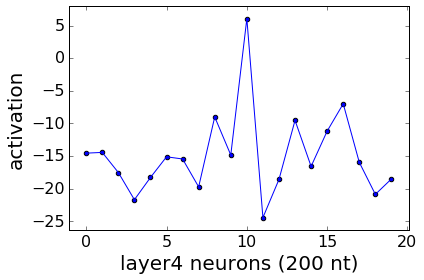

In [210]:
# get dense layer
get_conv4 = theano.function([nnmodel.input_var], layers.get_output(network['conv4'], deterministic=True), allow_input_downcast=True)
conv4 = get_conv4(X)
conv4_flat = np.squeeze(conv4[0],axis=2)


fig = plt.figure()
plt.plot(conv4_flat);
plt.scatter(range(20),conv4_flat);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer4 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'conv4_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])

        
threshold = np.max(conv4)*.9
conv4[conv4<threshold] = 0


In [211]:

conv4 = np.zeros(20)
conv4[class_index]=10
conv4 = np.expand_dims(conv4,0)
conv4 = np.expand_dims(conv4,2)
conv4 = np.expand_dims(conv4,3)


0

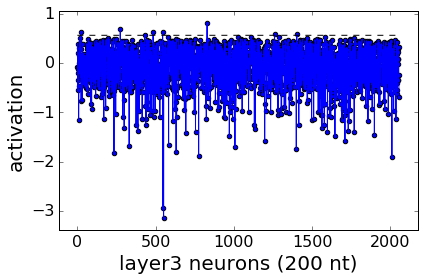

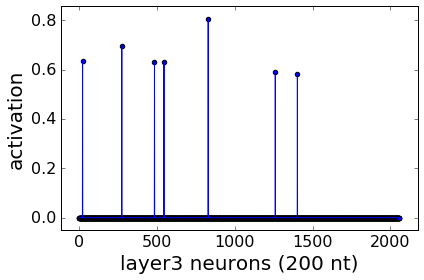

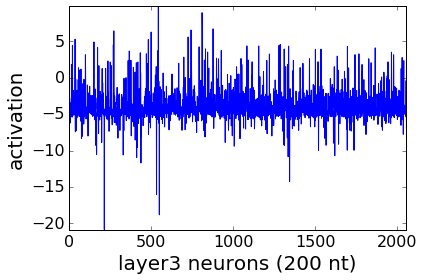

In [220]:
conv3 = deconvolution(conv4, network['conv4'])
conv3_flat = np.squeeze(conv3[0],axis=2)

fig = plt.figure()
plt.plot(conv3_flat);
plt.scatter(range(len(conv3_flat)),conv3_flat);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer3 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)




threshold = np.max(conv3)*.6
conv3[conv3<threshold] = 0
plt.plot(range(len(conv3_flat)), np.ones(len(conv3_flat))*threshold, color='k', linestyle='--')
outfile = savedir+ 'deconv3_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])

conv3_flat = np.squeeze(conv3[0],axis=2)
fig = plt.figure()
plt.plot(conv3_flat);
plt.scatter(range(len(conv3_flat)),conv3_flat);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer3 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'deconv3_filter_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])



conv3_active = get_feature_map_all(network['conv3'], nnmodel.input_var, X)
fig = plt.figure()
plt.plot(np.squeeze(conv3_active[0]));
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer3 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'conv3_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])




0

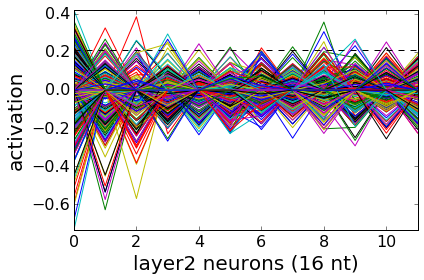

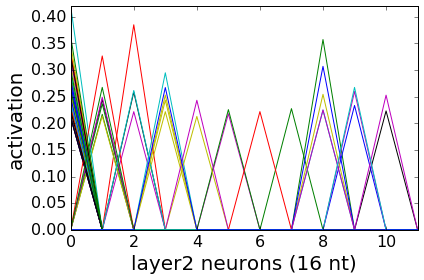

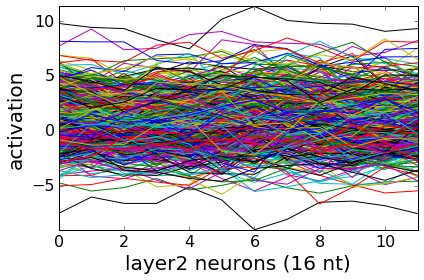

In [221]:
# get dense layer
#get_conv2 = theano.function([nnmodel.input_var], layers.get_output(network['conv2'], deterministic=True), allow_input_downcast=True)
#conv2 = get_conv2(X)

conv2_pool = deconvolution(conv3, network['conv3'])
conv2_active = get_feature_map_all(network['conv2'], nnmodel.input_var, X)
conv2 = maxunpool(X, conv2_pool, conv2_active)

conv2_flat = np.squeeze(conv2[0],axis=2)


fig = plt.figure()
plt.plot(conv2_flat.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer2 neurons (16 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)


threshold = np.max(conv2)*.5
conv2[conv2<threshold] = 0
plt.plot(range(len(conv2_flat)), np.ones(len(conv2_flat))*threshold, color='k', linestyle='--')
outfile = savedir+ 'deconv2_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])

conv2_flat = np.squeeze(conv2[0],axis=2)
fig = plt.figure()
plt.plot(conv2_flat.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer2 neurons (16 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'deconv2_filter_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])




fig = plt.figure()
plt.plot(np.squeeze(conv2_active[0],axis=2).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer2 neurons (16 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'conv2_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])




0

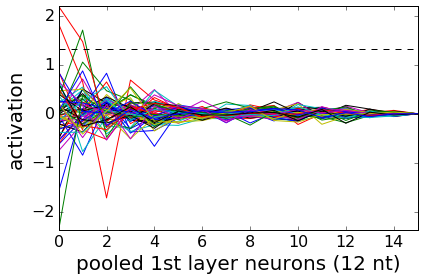

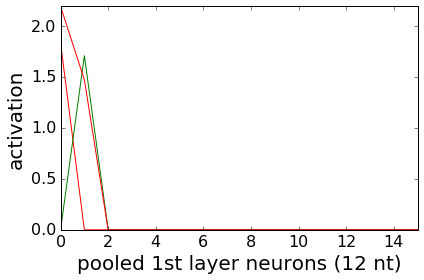

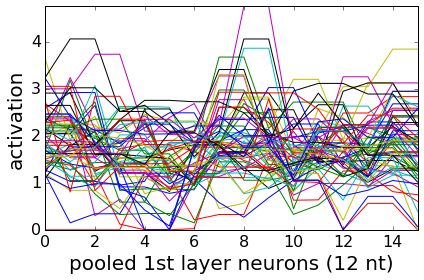

In [222]:

conv1_pool = deconvolution(conv2, network['conv2'])
pool = np.squeeze(conv1_pool[0])

fig=plt.figure()
plt.plot(pool.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('pooled 1st layer neurons (12 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)



threshold = np.max(conv1_pool)*.6
conv1_pool[conv1_pool<threshold] = 0
plt.plot(range(pool.shape[1]), np.ones(pool.shape[1])*threshold, color='k', linestyle='--')
outfile = savedir+ 'deconv1_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])

fig = plt.figure()
plt.plot(np.squeeze(conv1_pool[0]).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('pooled 1st layer neurons (12 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'deconv1_filter_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])



pool = get_feature_map_all(network['conv1_pool'], nnmodel.input_var, X)
fig = plt.figure()
plt.plot(np.squeeze(pool[0]).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('pooled 1st layer neurons (12 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'conv1pool_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])


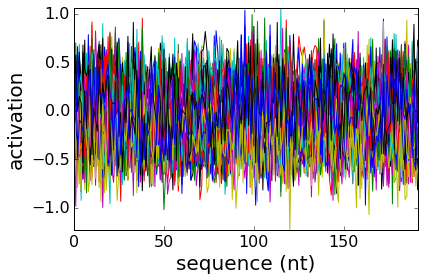

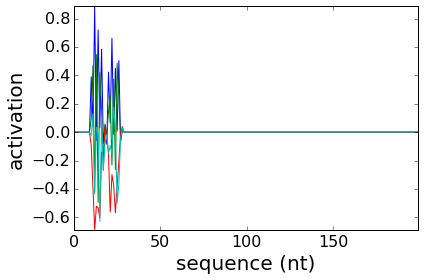

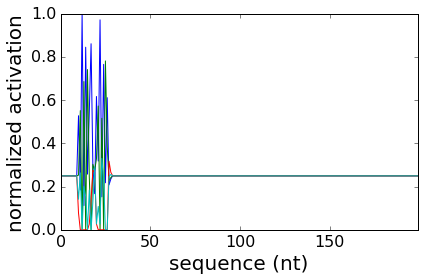

In [223]:
conv1_active = get_feature_map_all(network['conv1'], nnmodel.input_var, X)
conv1 = maxunpool(X, conv1_pool, conv1_active)
reconstruction = deconvolution(conv1, network['conv1'])


fig = plt.figure()
plt.plot(np.squeeze(conv1_active[0]).T)
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'conv1_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000) 


fig = plt.figure()
plt.plot(np.squeeze(reconstruction[0]).T)
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'deconv0_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000) 

#reconstruction[reconstruction<0]=0

pwm = np.squeeze(reconstruction[0])
pwm = pwm/np.max(pwm)
pwm += .2
pwm[pwm<0] = 0
#pwm = pwm + np.mean(pwm)
norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
pwm = pwm/norm

fig = plt.figure()
plt.plot(pwm.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('normalized activation', fontsize=20)
outfile = savedir+ 'deconv0_normalized_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  



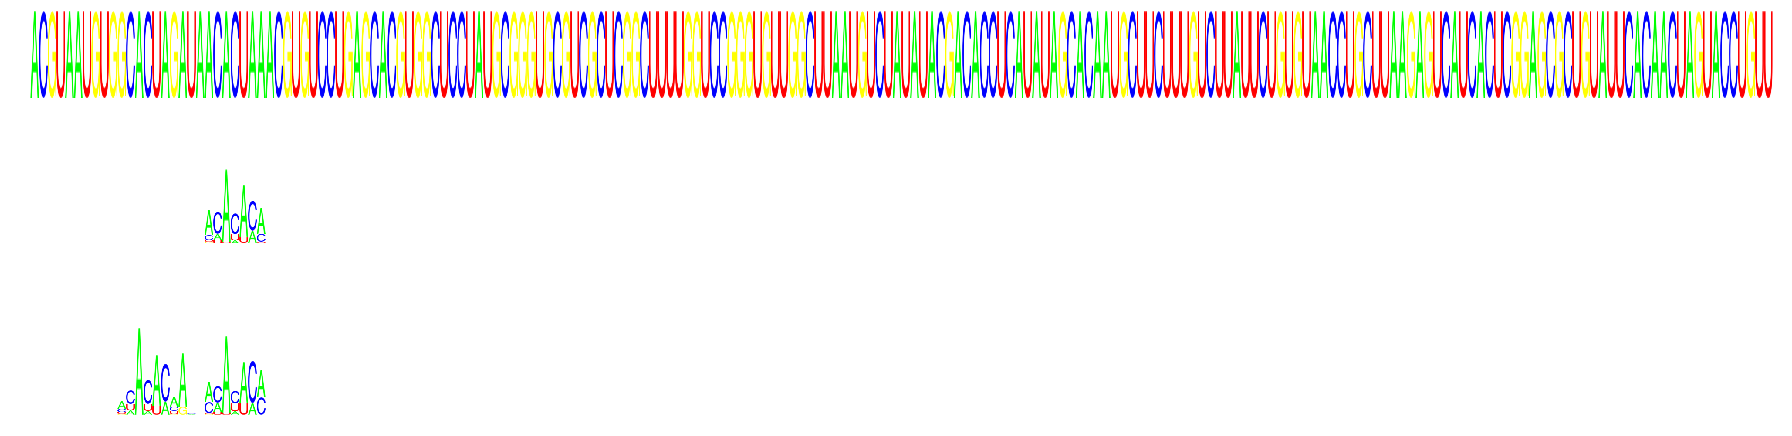

In [224]:
height=100
bp_width=20
size = (25.,10.0)

logo = seq_logo(np.squeeze(X[0]), height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);

plt.subplot(3,1,1)
plt.imshow(logo, interpolation='none');
plt.axis('off');


plt.subplot(3,1,2)
logo = seq_logo(model, height, bp_width, norm=0, rna=1, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');


plt.subplot(3,1,3)
logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');
outfile = savedir+ 'reconstructed_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  


In [ ]:
# get dense layer
get_conv2 = theano.function([nnmodel.input_var], layers.get_output(network['conv2'], deterministic=True), allow_input_downcast=True)
conv2 = get_conv2(X)

plt.figure()
plt.plot(np.squeeze(conv2[0]));
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('2nd layer neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'po'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])


conv1_pool = deconvolution(conv2, network['conv2'])

plt.figure()
plt.plot(np.squeeze(conv1_pool[0]).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('pooled 1st layer neurons (20 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)

conv1_active = get_feature_map_all(network['conv1'], nnmodel.input_var, X)
conv1 = maxunpool(X, conv1_pool, conv1_active)
reconstruction = deconvolution(conv1, network['conv1'])

plt.figure()
plt.plot(np.squeeze(reconstruction[0]).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)


pwm = np.squeeze(reconstruction[0])
pwm = pwm/np.max(pwm)
pwm += .33
pwm[pwm<0] = 0
#pwm = pwm + np.mean(pwm)
norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
pwm = pwm/norm


plt.figure()
plt.plot(pwm.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('normalized activation', fontsize=20)


height=100
bp_width=20
size = (25.,10.0)
logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
